# MLP Network


## 1. Pretreatment


Read data from `.mat` files.

In [1]:
import scipy as sp
import torch
import torch.nn as nn
from torchinfo import summary

torch.set_default_dtype(torch.float64)
Input = sp.io.loadmat("Data/KinematicsData.mat")
Input = torch.from_numpy(Input["KinematicsData"])
Output = sp.io.loadmat("Data/DynRegVecData.mat")
Output = torch.from_numpy(Output["DynRegData"])

Size of input and output data.

In [2]:
Input.shape, Output.shape

(torch.Size([50000, 6]), torch.Size([50000, 14]))

import `utils` module.

In [3]:
import sys

sys.path.append("..")
from utils import *

Create **Training** and **Validation** datasets.

In [4]:
TrainingLoader, ValidationLoader = Split2Loaders(
    Input, Output, BATCHSIZE=32, RATIO=0.8, SHUFFLE=True
)

## 2. Training


Define MLP network structure.

In [5]:
class DynReg_MLP(nn.Module):
    def __init__(self, input_size, output_size, embedding_size, hidden_size=None):
        if hidden_size is None:
            hidden_size = [16, 32, 16]
        super().__init__()

        # 创建一个线性层的列表
        self.layers = nn.ModuleList()

        self.LinearLayerStruct = [input_size] + hidden_size + [embedding_size]
        for i in range(len(self.LinearLayerStruct) - 1):
            self.layers.append(
                nn.Linear(self.LinearLayerStruct[i], self.LinearLayerStruct[i + 1])
            )

        self.LinearMapping = nn.Linear(embedding_size, output_size, bias=False)

    def forward(self, x):
        Output = x
        for layer in self.layers:
            Output = layer(Output)
            Output = torch.relu(Output)
        Output = self.LinearMapping(Output)
        return Output

Define network.

In [6]:
Net = DynReg_MLP(
    input_size=Input.shape[1],
    output_size=Output.shape[1],
    embedding_size=8,
    hidden_size=[16, 32, 16],
)
summary(
    Net,
    input_data=torch.zeros(1, Input.shape[1]),
    device=GET_DEVICE(),
    col_names=["input_size", "output_size", "num_params"],
    col_width=15,
)

Layer (type:depth-idx)                   Input Shape     Output Shape    Param #
DynReg_MLP                               [1, 6]          [1, 14]         --
├─ModuleList: 1-1                        --              --              --
│    └─Linear: 2-1                       [1, 6]          [1, 16]         112
│    └─Linear: 2-2                       [1, 16]         [1, 32]         544
│    └─Linear: 2-3                       [1, 32]         [1, 16]         528
│    └─Linear: 2-4                       [1, 16]         [1, 8]          136
├─Linear: 1-2                            [1, 8]          [1, 14]         112
Total params: 1,432
Trainable params: 1,432
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

Define loss function.

In [7]:
def LinearMappingSparityLoss(Network, OutputFromNet, OutputFromData):
    return torch.abs(Network.LinearMapping.weight).sum()

Define optimizer.

In [8]:
optimizer = torch.optim.Adam(Net.parameters(), lr=0.001, weight_decay=0)

Initialize weight.

In [9]:
INIT_WEIGHTS_XAVIER(Net)

Define training configuration.

In [10]:
num_epochs = 20
loss_weights = [1, 1e-2]
grad_max = 5
loss_switch_value = 5
freeze_epoch = 7


Training network.

In [11]:
(
    Loss_1_Training_History,
    Loss_1_Validation_History,
    Loss_2_Training_History,
    Loss_2_Validation_History,
) = TRAIN_WITH_PROGRESS_BAR_TWO_LOSS(
    MODEL=Net,
    NUM_EPOCHS=num_epochs,
    OPTIMIZER=optimizer,
    TRAIN_LOADER=TrainingLoader,
    VALIDATION_LOADER=ValidationLoader,
    LOSS_TUPLE=[
        nn.MSELoss(),
        lambda y1, y2: LinearMappingSparityLoss(Net, y1, y2),
    ],
    LOSS_WEIGHTS=loss_weights,
    DEVICE=0,
    GRAD_MAX=grad_max,
    LOSS_SWITCH_VALUE=loss_switch_value,
    FREEZE_EPOCH=freeze_epoch,
    FREEZE_LAYER=Net.LinearMapping,
)

PyTorch Version: 2.2.2
Training on cuda:0
====================================Start training====================================


Epoch 20/20: 100%|██████████| 1250/1250 [00:04<00:00, 269.82batch/s, loss_1=3.31, loss_2=3.04]


====================================Finish training====================================



Visualization.

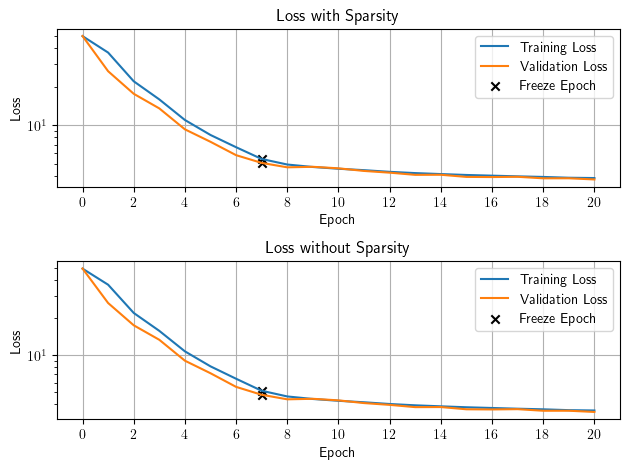

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["text.usetex"] = True
x_axis_segments = 10

fig, ax = plt.subplots(2, 1)
ax[0].plot(
    np.arange(0, len(Loss_1_Training_History)),
    Loss_1_Training_History,
    label="Training Loss",
)
ax[0].plot(
    np.arange(0, len(Loss_1_Validation_History)),
    Loss_1_Validation_History,
    label="Validation Loss",
)
ax[0].scatter(
    [freeze_epoch, freeze_epoch],
    [
        Loss_1_Training_History[freeze_epoch],
        Loss_1_Validation_History[freeze_epoch],
    ],
    label="Freeze Epoch",
    color="black",
    marker="x",
)
ax[0].set_title("Loss with Sparsity")
ax[0].set_xticks(np.linspace(0, num_epochs, x_axis_segments + 1, dtype=int))
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_yscale("log")
ax[0].legend()
ax[0].grid()

ax[1].plot(
    np.arange(0, len(Loss_2_Training_History)),
    Loss_2_Training_History,
    label="Training Loss",
)
ax[1].plot(
    np.arange(0, len(Loss_2_Validation_History)),
    Loss_2_Validation_History,
    label="Validation Loss",
)
ax[1].scatter(
    [freeze_epoch, freeze_epoch],
    [
        Loss_2_Training_History[freeze_epoch],
        Loss_2_Validation_History[freeze_epoch],
    ],
    label="Freeze Epoch",
    color="black",
    marker="x",
)
ax[1].set_title("Loss without Sparsity")
ax[1].set_xticks(np.linspace(0, num_epochs, x_axis_segments + 1, dtype=int))
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].set_yscale("log")
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()

Final loss.

In [13]:
Loss_2_Validation_History[-1]

tensor(3.4818)

Linear Mapping Matrix Visualization.

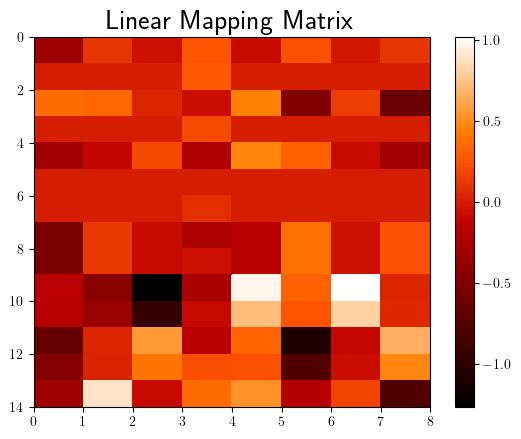

In [14]:
plt.pcolor(Net.LinearMapping.weight.detach().to("cpu").numpy(), cmap="gist_heat")
plt.colorbar()
plt.gca().invert_yaxis()
plt.title("Linear Mapping Matrix", fontsize=20)
plt.show()

Linear Layer Weight Visualization.

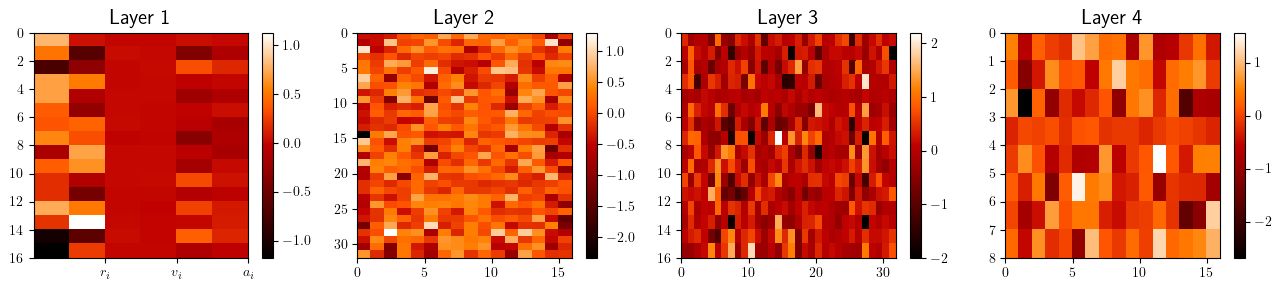

In [15]:
fig, ax = plt.subplots(
    1, len(Net.layers), figsize=(3 * len(Net.layers) + 1, 3), dpi=100
)

for index, layer in enumerate(Net.layers):
    CurrentPlot = ax[index].pcolor(
        layer.weight.detach().to("cpu").numpy(), cmap="gist_heat"
    )
    ax[index].invert_yaxis()
    ax[index].set_title(f"Layer {str(index + 1)}", fontsize=15)
    plt.colorbar(CurrentPlot, ax=ax[index])
    if index == 0:
        ax[index].set_xticks([2, 4, 6])
        ax[index].set_xticklabels([r"$r_i$", r"$v_i$", r"$a_i$"])
plt.tight_layout()